### Dataset

In this homework, we continue using the fuel efficiency dataset.
('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')


The goal of this homework is to create a regression model for predicting the car fuel efficiency (column `'fuel_efficiency_mpg'`).

In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
df.head(3)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341


### Preparing the dataset 

Preparation:

* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=False)` to turn the dataframes into matrices.

In [3]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [4]:
df = df.fillna(0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [5]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [6]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_train = df_train['fuel_efficiency_mpg']
y_val = df_val['fuel_efficiency_mpg']

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit_transform(dict_train)
X_train = dv.transform(dict_train)
X_val = dv.transform(dict_val)
len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

## Question 1

Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?


* `'vehicle_weight'`
* `'model_year'`
* `'origin'`
* `'fuel_type'`

In [7]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



`'vehicle_weight'` is used to split the data.

## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 0.045
* 0.45
* 4.5
* 45.0

In [8]:
from sklearn.ensemble  import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_val, y_pred)

0.4443178455925074

The RMSE of this model on validation data is `0.45`.

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

If it doesn't stop improving, use the latest iteration number in
your answer.

In [9]:
RMSE_Q3 = []
for n_est in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    RMSE_Q3.append([n_est, round(root_mean_squared_error(y_val, y_pred), 3)])

df_RMSE_Q3 = pd.DataFrame(RMSE_Q3, columns=['n_estimators', 'RMSE'])
df_RMSE_Q3

,n_estimators,RMSE
0,10,0.460
1,20,0.454
2,30,0.451
3,40,0.448
4,50,0.446
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.444


Text(0, 0.5, 'RMSE')

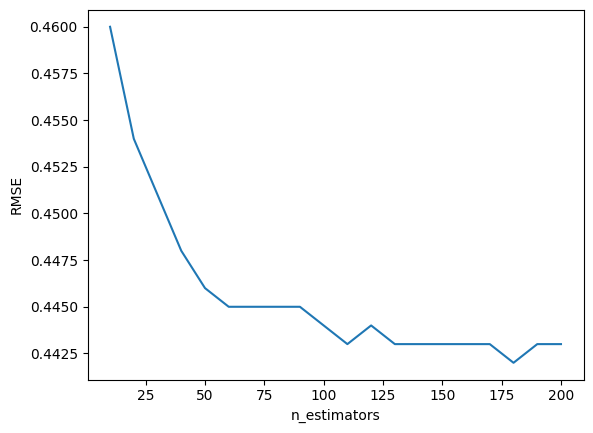

In [10]:
from matplotlib import pyplot as plt
plt.plot(df_RMSE_Q3['n_estimators'], df_RMSE_Q3['RMSE'])
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

After n_estimators=180 RMSE stops improving. Hence, I choose the closest option `n_estimators=200`.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [11]:
import numpy as np
max_depth_Q4 = [10, 15, 20, 25]
RMSE_Q4 = []
for depth in max_depth_Q4:
    RMSE = []
    for n_est in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=depth, n_estimators=n_est, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        RMSE.append(root_mean_squared_error(y_val, y_pred))

    RMSE_Q4.append([depth, np.mean(RMSE)])
df_RMSE_Q4 = pd.DataFrame(RMSE_Q4, columns=['max_depth', 'RMSE'])
df_RMSE_Q4

,max_depth,RMSE
0,10,0.442321
1,15,0.445060
2,20,0.445644
3,25,0.445661


`max_depth=10` achieves the best mean RMSE.

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `vehicle_weight`
*	`horsepower`
* `acceleration`
* `engine_displacement`	